In [124]:
##imports for notebook
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor, nn 

In [2]:
MNIST_URL = "http://deeplearning.net/data/mnist/mnist.pkl"

In [177]:
#downloading the mnist dataset from deeplearning.net
path = datasets.download_data(MNIST_URL, ext='.gz')
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f,encoding='latin-1')

In [178]:
#converting our numpy arrays into pytorch tensors
x_train, y_train, x_valid, y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()
#showing our input training images tensors
#showing the shape of the training image tensors
#showing the cooresponding actuals
#showing the shape of the cooresponding actuals
#showing the range of our categories (numbers 0->9)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [9]:
assert n == y_train.shape[0] == 50000 #testing the number of rows are equal, 50000 data points
assert(c == 28*28)
assert(y_train.min() == 0)
assert(y_train.max()== 9)

torch.FloatTensor


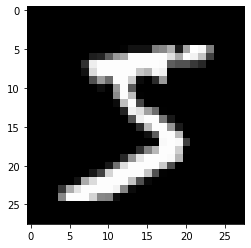

In [14]:
#showing an example image of the training dataset
mpl.rcParams['image.cmap'] = 'gray' #ensuring matplot lib knows we're grayscaled
img = x_train[0] #first image in the dataset
print(img.view(28,28).type())
plt.imshow(img.view((28,28)));

In [15]:
#setting up the model
weights = torch.randn(784, 10) #network input,output size
bias = torch.zeros(10)

In [228]:
def matmul(a,b): #affine function
    ar,ac = a.shape
    br, bc = b.shape
    assert ac == br #matrix multiply size test
    c = torch.zeros(ar, bc) #result matrix
    for i in range(ar):
           c[i] = (a[i].unsqueeze(-1) * b).sum(dim = 0) #summing over 0-axis (rows)
    return c

def ein_sum_matmul(a,b): #outputting i rows, j columns over the shared k index values
        return torch.einsum('ik,kj->ij', a, b)
    
def diag(arr: torch.Tensor):
    return torch.einsum('ii -> i', arr)
    
#L2 Norm, the Frobenius Norm, sqrt of the sum of the absolute squares
def frob_norm(a: torch.Tensor):
    return (a*a).sum().sqrt()

def test_near(a,b):
        return torch.allclose(a,b, rtol=1e-3, atol=1e-5)
    
def test_near_zero(a, tol=1e-3):
        assert a.abs() < tol, f"Near zero: {a}"
        
def normalize(x, m, s): return (x-m)/s

def slope_intercept(x, w, b): #
        return x@w + b
    
def relu(x):
    return x.clamp_min(0.)

def relu_subhalf(x):
    return x.clamp_min(0.) - 0.5

#MSE loss function - not really used
def mse(output, target):
    return (output.squeeze(1) - target).pow(2).mean() #output is single axis

def model(xb):
    l1 = slope_intercept(xb, w1, b1)
    l2 = relu_subhalf(l1)
    l3 = slope_intercept(l2, w2, b2)
    return l3

def mse_gradient(inp, target):
        inp.g = 2. * (inp.squeeze() - target).unsqueeze(-1) / inp.shape[0]
    
def relu_gradient(inp, output):
        inp.g = (inp>0).float() * output.g
        
def slope_intercept_grad(inp, output, w, b):
        inp.g = output.g @ w.t()
        w.g = (inp.unsqueeze(-1) * output.g.unsqueeze(1)).sum(0)
        b.g = output.g.sum(0)


Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

In [73]:
mat1 = x_valid[:5]
mat2 = weights
print(mat1.shape, mat2.shape)
%time result = matmul(mat1, mat2)
print(result.shape)

torch.Size([5, 784]) torch.Size([784, 10])
Wall time: 1 ms
torch.Size([5, 10])


In [90]:
a_normalize = frob_norm(mat1)
assert(test_near(result, matmul(mat1,mat2)) == True)
%timeit -n 10 result = ein_sum_matmul(mat1, mat2)
assert(test_near(result, ein_sum_matmul(mat1, mat2)) == True)

103 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [92]:
#pytorch matmul
%timeit -n 10 pyt_result = mat1@mat2

37.8 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [182]:
#normalize our data
training_mean, training_std = x_train.mean(), x_train.std()
validation_mean, validation_std = x_valid.mean(),x_valid.std()

x_train = normalize(x_train, training_mean, training_std)
x_valid = normalize(x_train, validation_mean, validation_std)
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [183]:
n, m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

In [320]:
# kaiming init / he init for relu
nh = 50
w1 = torch.randn(m,nh)*math.sqrt(2./m )
b1 = torch.zeros(nh)
t1 = relu_subhalf(slope_intercept(x_valid, w1, b1))
print(t1.mean(),t1.std())
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)

tensor(0.8518) tensor(2.3361)


In [199]:
# %timeit -n 10 _=model(x_valid[:10000])

In [321]:
y_train, y_valid = y_train.float(), y_valid.float()

In [322]:
predictions = model(x_train)
mse(predictions, y_train)

tensor(27.4452)

In [323]:
def forward_and_backward(inp, target):
    #forward pass
    l1 = inp @ w1 + b1
    l2 = relu_subhalf(l1)
    output = l2 @w2 + b2
    
    loss = mse(output, target)
    
    #backward pass
    mse_gradient(output, target)
    slope_intercept_grad(l2, output, w2, b2)
    relu_gradient (l1, l2)
    slope_intercept_grad(inp, l1, w1, b2)

forward_and_backward(x_train, y_train)

In [324]:
#saving old gradients
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig  = x_train.g.clone()

AttributeError: 'Tensor' object has no attribute 'g'

In [291]:
#calculating gradients with Torch's autograd
x_train_c = x_train.clone().requires_grad_(True)
w1_c = w1.clone().requires_grad_(True)
w2_c = w2.clone().requires_grad_(True)
b1_c = b1.clone().requires_grad_(True)
b2_c = b2.clone().requires_grad_(True)

In [273]:
def forward(inp, target):
    l1 = inp @ w1_c + b1_c
    l2 = relu(l1)
    output = l2@w2_c + b2_c
    return mse(output, target)

In [274]:
loss = forward(x_train_c, y_train)
loss.backward() #backward pass using Pytorch's autograd

In [275]:
test_near(w2_c.grad, w2g)
test_near(b2_c.grad, b2g)
test_near(w1_c.grad, w1g)
test_near(b1_c.grad, b1g)
test_near( x_train_c.grad, ig)

NameError: name 'b2g' is not defined